# Assignment 3.

## Student Name/ID: YukiTome/m5271046


---

## Create Convolutional Neural network using PyTorch

The aim of this assignment is to create improved version, comparing to the one used in exercise 3, using PyTorch library.

In [1]:
import torch
from torch import nn
import numpy as np
import math
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

In [2]:
torch.manual_seed(2)  # we set up a seed so that your output matches ours although the initialization is random.
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Next, we need to define helper functions to load data. 

In [3]:
def load_dataset():
    train_dataset = h5py.File('/datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # your train set labels

    test_dataset = h5py.File('/datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
# Loading the data (signs)
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

In this assignment you will use the same dataset as in the exercise 3. 

The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 1


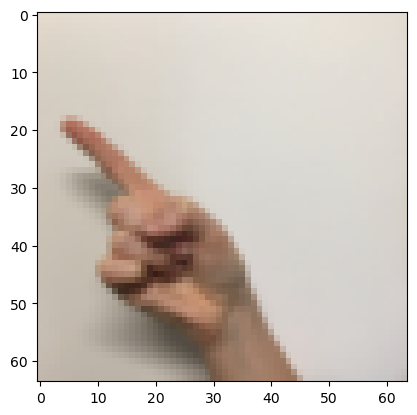

In [5]:
# Example of a picture
index = 7
plt.imshow(train_set_x_orig[index])
print("y = " + str(np.squeeze(train_set_y_orig[:, index])))

Now, you can reshape and 'standardize' dataset.

In [6]:
train_set_x = np.reshape(train_set_x_orig, (1080, 3, 64, 64))/255.
test_set_x = np.reshape(test_set_x_orig, (120, 3, 64, 64))/255.
train_set_y = np.reshape(train_set_y_orig, -1).T
test_set_y = np.reshape(test_set_y_orig, -1).T

print("number of training examples = " + str(train_set_x.shape[0]))
print("number of test examples = " + str(test_set_x.shape[0]))
print("X_train shape: " + str(train_set_x.shape))
print("Y_train shape: " + str(train_set_y.shape))
print("X_test shape: " + str(test_set_x.shape))
print("Y_test shape: " + str(test_set_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 3, 64, 64)
Y_train shape: (1080,)
X_test shape: (120, 3, 64, 64)
Y_test shape: (120,)


In this assignment you will also train your model with mini-batches to speed up parameter training process.

Here's helper function to split data into batches. This function will be implemented with numpy, and we will retrieve these batches later during training. So, PyTorch Tensors for training will be created after obtaining data with this function.

In [7]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size)  # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size: m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

Now you can create Tensors for testing.

**Hint**

In previous week assignment and exercise Tensor type of input `x` and output `y` was the same, since binary cross-entropy function expects `FloatTensor` as target output `y`. In this week exercise and assignment we will use cross-entropy cost function, because number of classes in the SIGNS dataset is more than 2. This function expects `LongTensor` as target output `y`.

In [8]:
X_test = torch.tensor(test_set_x, device=device, dtype=dtype, requires_grad=False)
Y_test = torch.tensor(test_set_y, device=device, dtype=torch.long)

## Problem 1

### Calculate padding

As you can see in the exercise 3, padding size is hard coded in the model class. This might be very inconvenient during hyper-parameter fine-tuning.

Define function `calculate_padding()` taking into account kernel size. NOTE: Assume that the stride is 2 and the output image should be two times smaller, i.e. 32x32 becomes 16x16.

In [9]:
def calculate_padding(kernel_size):
    """
    Arguments:
    kernel_size -- int, size of CNN kernel
    Returns:
    padding_size -- int, number of zeros to pad input.
    """

    # Your code here !!
    stride = 2
    padding_size = math.ceil((kernel_size / stride) - 1)

    return padding_size

In [10]:
print('Padding for kernel size = 11 is {}'.format(calculate_padding(11)))
# Expected output: 5

Padding for kernel size = 11 is 5


## Problem 2

### Calculate the size of the last Linear layer

Define function `output_layer_size()` given input_shape and list of strides used in the model.

In [11]:
def output_layer_size(input_shape, strides, last_filter):
    """
    Arguments:
    input_shape -- list of integers containing height and width of image
    strides -- list of integers containing stride used in the model
    last_filter -- int, number of output channels in the last Conv layer
    Returns:
    output_size -- int, size of input to the Linear layer
    """
    output_height, output_width = input_shape

    for stride in strides:
        output_height = output_height / stride
        output_width = output_width / stride

    output_size = last_filter * output_height * output_width
    
    return int(output_size)

In [12]:
print('Output size of Conv model: {}'.format(output_layer_size([28, 28], [2, 2], 16)))
# Expected output: 784

Output size of Conv model: 784


## Problem 3

### Create improved Conv model

Here you need to create a class to defined improved Conv model. Your class should have similar structure as the one we created during exercise. 

Use functions we created in **Problem 1** and **Problem 2** to obtain correct codding and size of Linear output layer.

This class will contain three layers:
1. 2D convolutional layer `Conv2d` with `ReLu` activation function and [Batch Normalization](https://pytorch.org/docs/master/nn.html#normalization-layers), expects any kernel size,
2. 2D convolutional layer `Conv2d` with `ReLu` activation function and [Batch Normalization](https://pytorch.org/docs/master/nn.html#normalization-layers), expects any kernel size,
3. `Linear` layer without activation function.

In [13]:
class CNN(nn.Module):
    def __init__(self, image_shape, filters, kernels, strides, n_out):
        super(CNN, self).__init__()
        """
        Arguments:
        image_shape: python list containing shape of input image [channel, height, width]
        filters: python list of integers, defining the number of filters in the Conv layers
        kernels: python list of integers, defining kernel height and width
        strides: python list of integers, defining stride for each Conv layer
        n_out: number of output classes
        
        """
        # Your code here !!!
        # Define 1st convolutional layer
        padding1 = calculate_padding(kernels[0])
        self.conv1 = nn.Sequential(
            nn.Conv2d(image_shape[0], filters[0], kernel_size=kernels[0], stride=strides[0], padding=padding1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU()
        )
        
        # Calculate the output shape after the 1st convolutional layer
        output_shape1 = [image_shape[1] // strides[0], image_shape[2] // strides[0]]

        # Define 2nd convolutional layer
        padding2 = calculate_padding(kernels[1])
        self.conv2 = nn.Sequential(
            nn.Conv2d(filters[0], filters[1], kernel_size=kernels[1], stride=strides[1], padding=padding2),
            nn.BatchNorm2d(filters[1]),
            nn.ReLU()
        )
        
        # Calculate the output shape after the 2nd convolutional layer
        output_shape2 = [output_shape1[0] // strides[1], output_shape1[1] // strides[1]]
        
        # Calculate input size to linear layer
        linear_input_size = output_layer_size(output_shape2, [1], filters[1])
        
        # Define the Linear layer
        self.out = nn.Linear(linear_input_size, n_out)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  
        output = self.out(x)
        return output

Now you can check your model by passing hyper-parameters to its class.

In [14]:
# Declare hyper-parameters
input_shape = train_set_x.shape
filters = [8, 32]
kernels = [5, 3]
strides = [2, 2]
n_out = int(Y_test.max().item()) + 1

# Define model
model = CNN(input_shape[1:], filters, kernels, strides, n_out)
if torch.cuda.is_available():
    model.cuda()

print(model)
# Expected output: CNN(conv1: Sequential(0:..., 1:..., 2:...),
#                      conv2: Sequential(0:..., 1:..., 2:...), out: Linear...)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (out): Linear(in_features=8192, out_features=6, bias=True)
)


Let's define loss function and optimizer.

In [15]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

**Define training loop**

Now everything is ready to define our training loop using `model`, `loss` and `optimizer` created above. We don't need to pass those as parameters of train function, since they are declared as part of PyTorch computational Graph.

In [16]:
def train(train_x, train_y, X_test, Y_test, minibatch_size=64, num_epochs=20, seed=3):
    """
    Arguments:
    train_x -- numpy.array, training input,
    train_y -- numpy.array, training output target,
    X_test -- Tensor, test input,
    Y_test -- Tensor, test output target,
    minibatch_size -- int, number of training samples per batch,
    num_epochs -- int, number of training epochs,
    seed -- int, seed of random number
    """
    for epoch in range(num_epochs):

        seed = seed + 1
        minibatches = random_mini_batches(train_x, train_y, minibatch_size, seed)

        for step, (minibatch_x, minibatch_y) in enumerate(minibatches):
            x = torch.tensor(minibatch_x, device=device, dtype=dtype, requires_grad=False)
            y = torch.LongTensor(minibatch_y, device=device)
            output = model(x)               # cnn output
            loss = loss_func(output, y)     # cross entropy loss
            optimizer.zero_grad()           # clear gradients for this training step
            loss.backward()                 # backpropagation, compute gradients
            optimizer.step()                # apply gradients

        print('Epoch: ', epoch+1, '| train loss: %.4f' % loss.data.cpu().numpy())

    test_output = model(X_test)
    train_output = model(torch.tensor(train_x, dtype=dtype, device=device))
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    pred_train_y = torch.max(train_output, 1)[1].data.squeeze()
    accuracy_test = float(sum(pred_y == Y_test)) / float(Y_test.size(0)) * 100
    accuracy_train = float(sum(pred_train_y.cpu().numpy() == train_y)) / float(train_y.shape[0]) * 100
    print('\nTrain accuracy: %.1f\n' % accuracy_train, 'Test accuracy: %.1f' % accuracy_test)

In [17]:
train(train_set_x, train_set_y, X_test, Y_test)

Epoch:  1 | train loss: 1.3159
Epoch:  2 | train loss: 1.3400
Epoch:  3 | train loss: 0.6223
Epoch:  4 | train loss: 0.2915
Epoch:  5 | train loss: 0.2033
Epoch:  6 | train loss: 0.0617
Epoch:  7 | train loss: 0.0924
Epoch:  8 | train loss: 0.0309
Epoch:  9 | train loss: 0.0350
Epoch:  10 | train loss: 0.0209
Epoch:  11 | train loss: 0.0115
Epoch:  12 | train loss: 0.0120
Epoch:  13 | train loss: 0.0065
Epoch:  14 | train loss: 0.0037
Epoch:  15 | train loss: 0.0038
Epoch:  16 | train loss: 0.0042
Epoch:  17 | train loss: 0.0027
Epoch:  18 | train loss: 0.0022
Epoch:  19 | train loss: 0.0015
Epoch:  20 | train loss: 0.0024

Train accuracy: 100.0
 Test accuracy: 93.3
